In [1]:
# note: same thing for REPL
# note: we use this instead of magic because `black` will otherwise fail to format
#
# Enable autoreload to automatically reload modules when they change

from IPython import get_ipython

# do this so that formatter not messed up
ipython = get_ipython()
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

# Import commonly used libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# graphics
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# type annotation
import jaxtyping
from jaxtyping import Float32, Int64, jaxtyped
from typeguard import typechecked as typechecker

# more itertools
import more_itertools as mi

# itertools
import itertools
import collections

# tensor manipulation
from einops import rearrange, reduce, repeat

# automatically apply jaxtyping
# %load_ext jaxtyping
# %jaxtyping.typechecker typeguard.typechecked

In [2]:
# note: same thing for REPL
# Enable autoreload to automatically reload modules when they change

from IPython import get_ipython

# do this so that formatter not messed up
ipython = get_ipython()
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

# Enable jaxtyping based typechecking
import jaxtyping
import typeguard

# Inline comment: This magic command enables runtime type checking using jaxtyping and typeguard
# ipython.run_line_magic("load_ext", "jaxtyping")

# Inline comment: This sets the typecheck mode to 'jaxtyping', which allows for more precise tensor shape checking
# ipython.run_line_magic("jaxtyping.typechecker", "typeguard.typechecked")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [277]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from typing import Tuple
from jaxtyping import Float  # For type annotations of tensors

# Set random seed for reproducibility
torch.manual_seed(0)


# Function to generate a toy circular dataset
def generate_circular_data(
    n_samples: int,
    noise_std: float = 0.05,
) -> Tuple[Float[torch.Tensor, "n_samples 2"], Float[torch.Tensor, "n_samples"]]:
    """
    Generates 'n_samples' points around the unit circle with optional Gaussian noise.

    Args:
        n_samples: Number of samples to generate.
        noise_std: Standard deviation of Gaussian noise added to the points.

    Returns:
        data: Tensor of shape [n_samples, 2], the x and y coordinates with noise.
        angles: Tensor of shape [n_samples], the original angles without noise.
    """
    # Sample angles uniformly between 0 and 2*pi
    angles: Float[torch.Tensor, "n_samples"] = torch.rand(n_samples) * 2 * torch.pi

    # Generate radii for three concentric circles
    radii: Float[torch.Tensor, "n_samples"] = (
        torch.randint(0, 3, (n_samples,)).float() + 1
    )

    # Generate x and y coordinates for three concentric circles
    x: Float[torch.Tensor, "n_samples"] = radii * torch.cos(angles)
    y: Float[torch.Tensor, "n_samples"] = radii * torch.sin(angles)

    # Stack the coordinates into a data tensor
    data: Float[torch.Tensor, "n_samples 2"] = torch.stack([x, y], dim=1)

    # Add Gaussian noise to the data
    data += torch.randn_like(data) * noise_std

    return data, angles

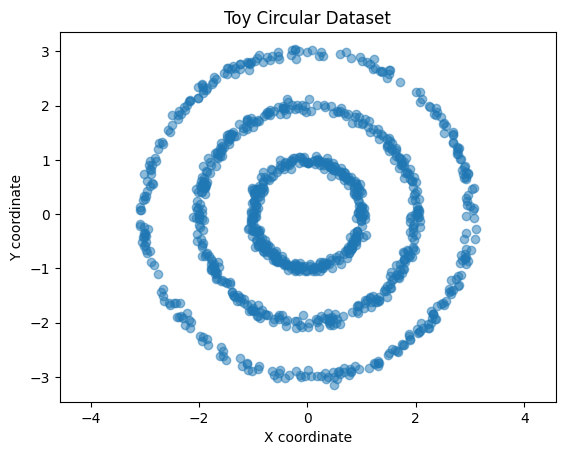

In [301]:
# Generate the dataset
n_samples = 1000
circular_data, angles = generate_circular_data(n_samples)

# Visualize the dataset
plt.scatter(circular_data[:, 0], circular_data[:, 1], alpha=0.5)
plt.axis("equal")
plt.title("Toy Circular Dataset")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.show()

In [302]:
import torch

# Assume 'data' and 'angles' are already defined from your circular dataset
# 'data' is of shape [n_samples, 2]
# 'angles' is of shape [n_samples]

n_samples = circular_data.shape[0]

# Generate the linear feature 'l' linearly increasing from 0 to 1
l = torch.linspace(0, 1, steps=n_samples)

# Shuffle 'l' to remove any unintended correlation with the data ordering
# l = l[torch.randperm(n_samples)]

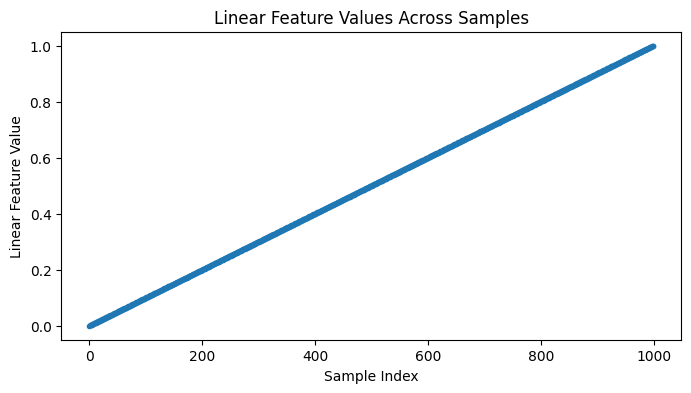

In [303]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(range(n_samples), l.numpy(), ".")
plt.title("Linear Feature Values Across Samples")
plt.xlabel("Sample Index")
plt.ylabel("Linear Feature Value")
plt.show()

In [304]:
# Combine the circular data with the linear feature to form a new dataset
# - l.unsqueeze(1) adds an extra dimension to l to make it a column vector of shape [n_samples, 1].
# - torch.cat([...], dim=1) concatenates the tensors along the feature dimension, resulting in a dataset with three features: [x, y, l].
# New data shape: [n_samples, 3]
data = torch.cat([circular_data, l.unsqueeze(1)], dim=1)

In [305]:
# Custom dataset class for our autoencoder
class AutoencoderDataset(torch.utils.data.Dataset):
    def __init__(self, data: Float[torch.Tensor, "n_samples 3"]):
        self.data = data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Float[torch.Tensor, "3"]:
        return self.data[idx]

In [306]:
# Function to compute the KL divergence sparsity penalty
def sparsity_penalty(
    z_mean: Float[torch.Tensor, "latent_dim"],
    sparsity_param: float,
) -> Float[torch.Tensor, ""]:
    """
    Computes the KL divergence between the average activation of the latent units and the desired sparsity parameter.

    Args:
        z_mean: Average activation of the latent units over the batch.
        sparsity_param: Desired average activation (sparsity level).

    Returns:
        penalty: The KL divergence sparsity penalty term.
    """
    # Clamp z_mean to avoid numerical instability and potential inf/nan values
    rho_hat = z_mean.clamp(min=1e-10, max=1 - 1e-10)
    rho = torch.tensor(sparsity_param, device=z_mean.device)

    # Compute element-wise KL divergence with additional safeguards
    kl_div = torch.where(
        rho > 0,
        rho * torch.log(torch.clamp(rho / rho_hat, min=1e-10, max=1e10)),
        torch.zeros_like(rho),
    ) + torch.where(
        (1 - rho) > 0,
        (1 - rho)
        * torch.log(torch.clamp((1 - rho) / (1 - rho_hat), min=1e-10, max=1e10)),
        torch.zeros_like(rho),
    )

    # Sum over latent dimensions to get the final penalty
    penalty = kl_div.sum()
    return penalty

In [316]:
import torch.nn.functional as F


# Define the full sparse autoencoder model by combining encoder and decoder
class SparseAutoencoder(nn.Module):
    """Sparse Autoencoder (SAE) model.

    This class implements a Sparse Autoencoder with linear encoder and decoder layers.
    It can be used to learn compressed representations of input data while enforcing sparsity.

    Args:
        d_input (int): Dimensionality of the input data.
        d_encoding (int): Dimensionality of the encoded (latent) representation.

    Example:
        # Create an SAE for activations of size 3 and hidden dimension 12
        sae = SparseAutoencoder(d_input=3, d_encoding=12)

        # Generate some random input data
        x = torch.randn(32, 3)  # 32 samples, 3 features each

        # Forward pass through the SAE
        encoded, decoded = sae(x)

        # encoded.shape will be (32, 12)
        # decoded.shape will be (32, 3)

        # Use encoded representations for downstream tasks or
        # compute reconstruction loss with decoded outputs
    """

    def __init__(self, d_input: int, d_encoding: int):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(d_input, d_encoding, bias=False)
        self.decoder = nn.Linear(d_encoding, d_input, bias=False)

    def forward(
        self,
        x: Float[torch.Tensor, "batch_size d_input"],
    ) -> Tuple[
        Float[torch.Tensor, "batch_size d_input"],
        Float[torch.Tensor, "batch_size d_encoding"],
    ]:
        encoded = F.gelu(self.encoder(x))  # Encode input to latent space
        decoded = self.decoder(encoded)  # Decode from latent space back to input space
        return decoded, encoded

In [317]:
input_dim = data.shape[1]  # Should be 3
latent_dim = 16  # As specified in your training

# Hyperparameters for training
num_epochs = 1000  # Number of training epochs
batch_size = 32  # Batch size for training
learning_rate = 1e-4  # Learning rate for optimizer
sparsity_param = 0.05  # Desired average activation of the hidden units
beta = 1e-3  # Weight of sparsity penalty term

In [318]:
# Create dataset and data loader
dataset = AutoencoderDataset(data)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [319]:
# Initialize the sparse autoencoder model, loss function, and optimizer
model = SparseAutoencoder(d_input=input_dim, d_encoding=latent_dim)
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer

In [320]:
# Training loop
for epoch in range(num_epochs):

    # Accumulate loss over the epoch
    epoch_loss = 0.0

    for batch_data in data_loader:
        x: Float[torch.Tensor, "batch_size 3"] = batch_data  # Input data batch

        # Forward pass: compute reconstructed output and latent representation
        reconstructed, z = model(x)

        # Compute the reconstruction loss
        recon_loss = criterion(reconstructed, x)

        # Compute the average activation of the latent units over the batch
        z_mean: Float[torch.Tensor, "latent_dim"] = z.mean(dim=0)

        # Compute the sparsity penalty term
        sparsity_loss = beta * sparsity_penalty(z_mean, sparsity_param)

        # Total loss combines reconstruction loss and sparsity penalty
        loss = recon_loss + sparsity_loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Accumulate loss
        epoch_loss += loss.item()
    # Compute average loss over the epoch
    avg_epoch_loss = epoch_loss / len(data_loader)
    # Print loss every 100 epochs to monitor training
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.6f}, Sparsity loss: {sparsity_loss:.6f}, Recon loss: {recon_loss:.6f}"
        )

Epoch [10/1000], Loss: 1.387064, Sparsity loss: 0.001284, Recon loss: 1.343852
Epoch [20/1000], Loss: 1.117254, Sparsity loss: 0.004743, Recon loss: 0.746445
Epoch [30/1000], Loss: 0.874915, Sparsity loss: 0.001811, Recon loss: 0.973847
Epoch [40/1000], Loss: 0.641667, Sparsity loss: 0.003606, Recon loss: 0.810599
Epoch [50/1000], Loss: 0.436985, Sparsity loss: 0.005710, Recon loss: 0.490197
Epoch [60/1000], Loss: 0.280558, Sparsity loss: 0.004263, Recon loss: 0.351841
Epoch [70/1000], Loss: 0.168846, Sparsity loss: 0.007166, Recon loss: 0.145779
Epoch [80/1000], Loss: 0.101548, Sparsity loss: 0.003762, Recon loss: 0.101758
Epoch [90/1000], Loss: inf, Sparsity loss: 0.006424, Recon loss: 0.069138
Epoch [100/1000], Loss: inf, Sparsity loss: inf, Recon loss: 0.046743
Epoch [110/1000], Loss: 0.037948, Sparsity loss: 0.002741, Recon loss: 0.029607
Epoch [120/1000], Loss: inf, Sparsity loss: inf, Recon loss: 0.027565
Epoch [130/1000], Loss: 0.029571, Sparsity loss: 0.008533, Recon loss: 0.0

In [321]:
# After training, obtain the latent representations of the data
with torch.no_grad():

    # Float[torch.Tensor, "n_samples latent_dim"]
    _, latent_reps = model(data)

In [322]:
# Visualize the latent representations
# Since latent_dim > 1, we can apply dimensionality reduction for visualization
from sklearn.decomposition import PCA

# Apply PCA to reduce latent representations to 2D for visualization
pca = PCA(n_components=2)
latent_reps_2d = pca.fit_transform(latent_reps.numpy())

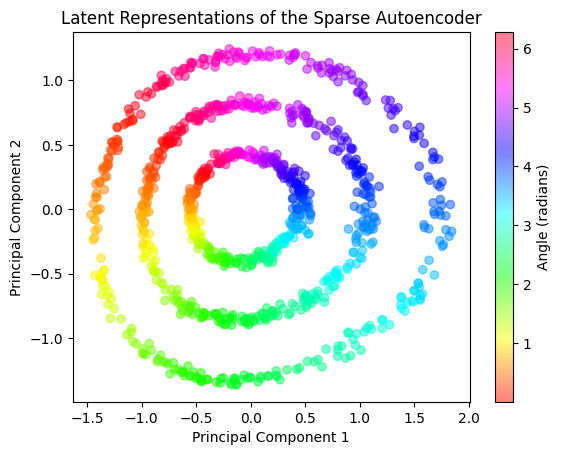

In [323]:
# Plot the latent representations
plt.scatter(
    latent_reps_2d[:, 0], latent_reps_2d[:, 1], c=angles.numpy(), cmap="hsv", alpha=0.5
)
plt.colorbar(label="Angle (radians)")
plt.title("Latent Representations of the Sparse Autoencoder")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [236]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
import numpy as np

In [237]:
# Ensure the model is in evaluation mode
model.eval()

# Use the trained encoder to obtain the latent representations
with torch.no_grad():
    # Pass data through encoder to get latent representations
    _, latent_reps = model(data)

In [238]:
# Convert tensors to numpy arrays for plotting
data_np = data.numpy()
latent_reps_np = latent_reps.numpy()
angles_np = angles.numpy()

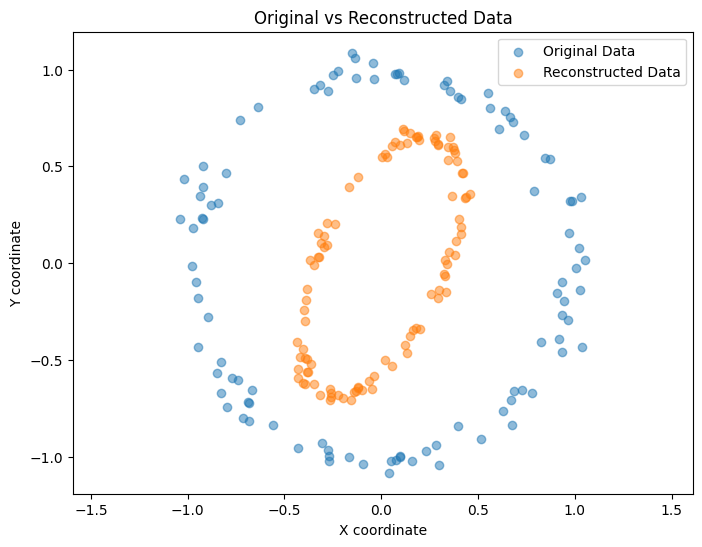

In [239]:
# Visualization 1: Original Data and Reconstructed Data

# Obtain reconstructed data from the model
with torch.no_grad():
    reconstructed_data, _ = model(data)
reconstructed_data_np = reconstructed_data.numpy()

# Plot original data and reconstructed data
plt.figure(figsize=(8, 6))
plt.scatter(data_np[:, 0], data_np[:, 1], label="Original Data", alpha=0.5)
plt.scatter(
    reconstructed_data_np[:, 0],
    reconstructed_data_np[:, 1],
    label="Reconstructed Data",
    alpha=0.5,
)
plt.legend()
plt.axis("equal")
plt.title("Original vs Reconstructed Data")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.show()

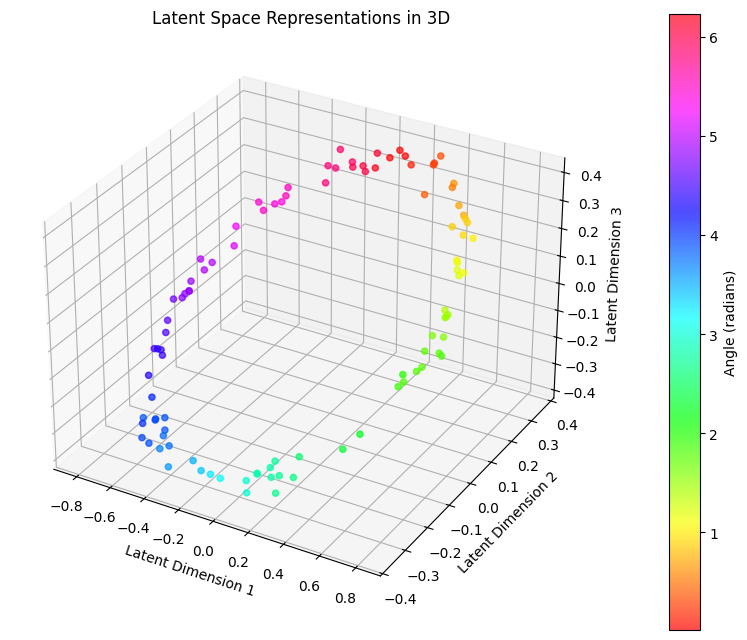

In [240]:
# Visualization 2: Latent Space Representations in 3D

# Create a 3D scatter plot of the latent representations
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Color points based on their original angle
scatter = ax.scatter(
    latent_reps_np[:, 0],
    latent_reps_np[:, 1],
    latent_reps_np[:, 2],
    c=angles_np,
    cmap="hsv",
    alpha=0.7,
)

# Add a color bar and labels
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Angle (radians)")
ax.set_title("Latent Space Representations in 3D")
ax.set_xlabel("Latent Dimension 1")
ax.set_ylabel("Latent Dimension 2")
ax.set_zlabel("Latent Dimension 3")
plt.show()

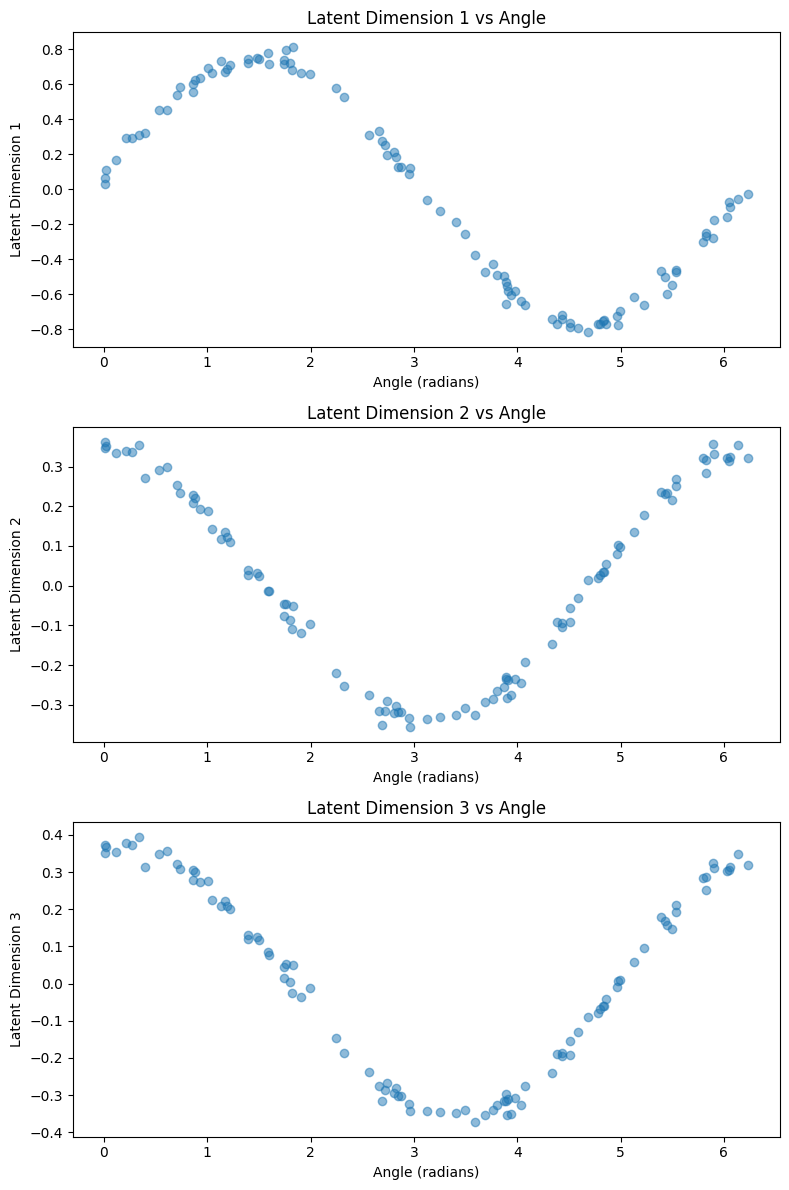

In [241]:
# Visualization 3: Relationship Between Latent Dimensions and Original Angles

# Plot each latent dimension against the original angle
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

for i in range(3):
    axes[i].scatter(angles_np, latent_reps_np[:, i], alpha=0.5)
    axes[i].set_title(f"Latent Dimension {i+1} vs Angle")
    axes[i].set_xlabel("Angle (radians)")
    axes[i].set_ylabel(f"Latent Dimension {i+1}")

plt.tight_layout()
plt.show()

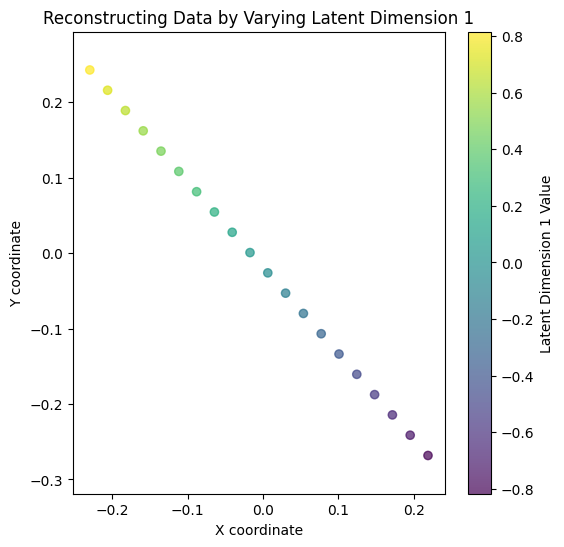

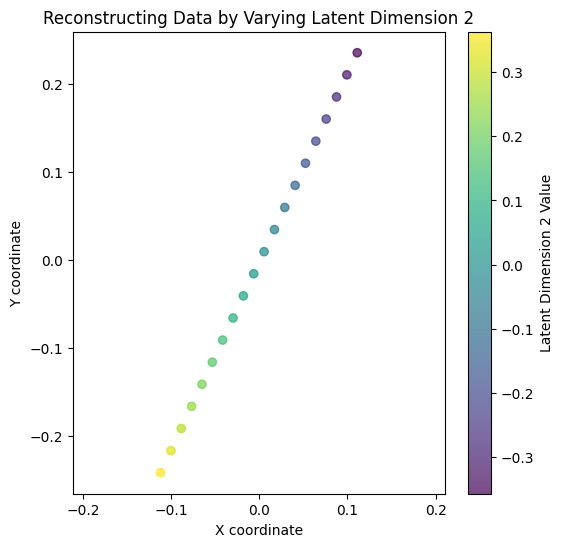

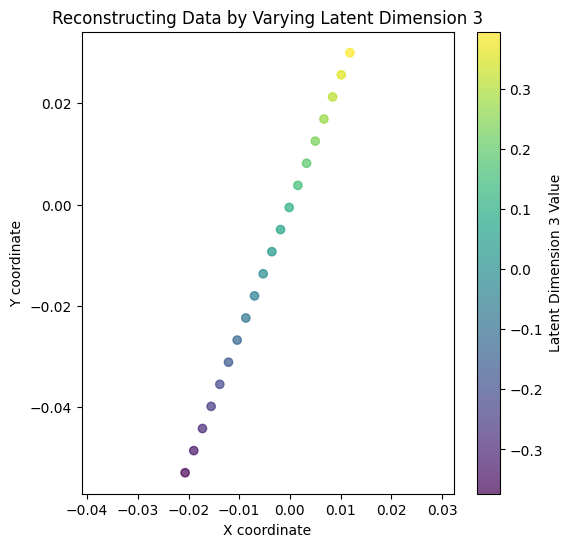

In [267]:
# Visualization 4: Reconstructed Data from Specific Latent Traversals

# Fix two latent dimensions and vary the third to see its effect on the reconstructed output

# Select a fixed point in latent space (e.g., the mean latent representation)
latent_mean = latent_reps.mean(dim=0).numpy()

# Number of steps to vary the latent dimension
num_steps = 20

# We'll vary each latent dimension separately while keeping others fixed
for i in range(3):
    # Create a figure for each latent dimension
    plt.figure(figsize=(6, 6))

    # Generate a range of values for the i-th latent dimension
    latent_vals = np.linspace(
        latent_reps_np[:, i].min(),
        latent_reps_np[:, i].max(),
        num_steps,
    )

    # Initialize list to store reconstructed outputs
    reconstructed_points = []

    for val in latent_vals:
        # Create a latent vector with the i-th dimension varying
        latent_vector = latent_mean.copy()
        latent_vector[i] = val
        latent_vector_tensor = (
            torch.from_numpy(latent_vector).float().unsqueeze(0)
        )  # Add batch dimension

        # Decode the latent vector to reconstruct data point
        with torch.no_grad():
            reconstructed_point = model.decoder(latent_vector_tensor).numpy()
        reconstructed_points.append(reconstructed_point)

    reconstructed_points = np.concatenate(reconstructed_points, axis=0)

    # Plot the reconstructed points
    plt.scatter(
        reconstructed_points[:, 0],
        reconstructed_points[:, 1],
        c=latent_vals,
        cmap="viridis",
        alpha=0.7,
    )
    plt.colorbar(label=f"Latent Dimension {i+1} Value")
    plt.title(f"Reconstructing Data by Varying Latent Dimension {i+1}")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.axis("equal")
    plt.show()

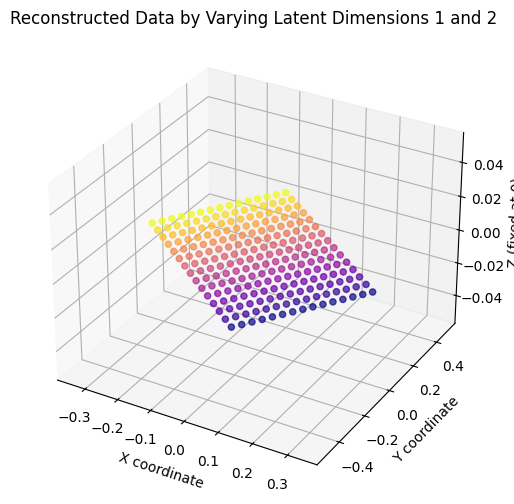

In [268]:
# Visualization 5: 3D Visualization of Latent Space Traversal

# Create a grid in the latent space by fixing one dimension and varying the other two
fixed_dim = 2  # The dimension to fix (0, 1, or 2)

# Fix the fixed_dim to its mean value
fixed_value = latent_mean[fixed_dim]

# Generate a grid of values for the other two dimensions
num_points = 15
latent_dim_1_vals = np.linspace(
    latent_reps_np[:, (fixed_dim + 1) % 3].min(),
    latent_reps_np[:, (fixed_dim + 1) % 3].max(),
    num_points,
)
latent_dim_2_vals = np.linspace(
    latent_reps_np[:, (fixed_dim + 2) % 3].min(),
    latent_reps_np[:, (fixed_dim + 2) % 3].max(),
    num_points,
)

# Meshgrid for the two varying dimensions
L1, L2 = np.meshgrid(latent_dim_1_vals, latent_dim_2_vals)

# Flatten the grid to create latent vectors
L1_flat = L1.flatten()
L2_flat = L2.flatten()

# Prepare the latent vectors
latent_vectors = []
for l1, l2 in zip(L1_flat, L2_flat):
    latent_vector = latent_mean.copy()
    latent_vector[(fixed_dim + 1) % 3] = l1
    latent_vector[(fixed_dim + 2) % 3] = l2
    latent_vectors.append(latent_vector)

latent_vectors_tensor = torch.from_numpy(np.array(latent_vectors)).float()

# Decode the latent vectors to reconstruct data points
with torch.no_grad():
    reconstructed_points = model.decoder(latent_vectors_tensor).numpy()

# Plot the reconstructed data in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    reconstructed_points[:, 0],
    reconstructed_points[:, 1],
    reconstructed_points[:, 0] * 0,  # Z=0 for 2D data
    c=L1_flat,  # Color by one of the latent dimensions
    cmap="plasma",
    alpha=0.7,
)
ax.set_title(
    f"Reconstructed Data by Varying Latent Dimensions {(fixed_dim + 1) % 3 +1} and {(fixed_dim + 2) % 3 +1}"
)
ax.set_xlabel("X coordinate")
ax.set_ylabel("Y coordinate")
ax.set_zlabel("Z (fixed at 0)")
plt.show()

In [244]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

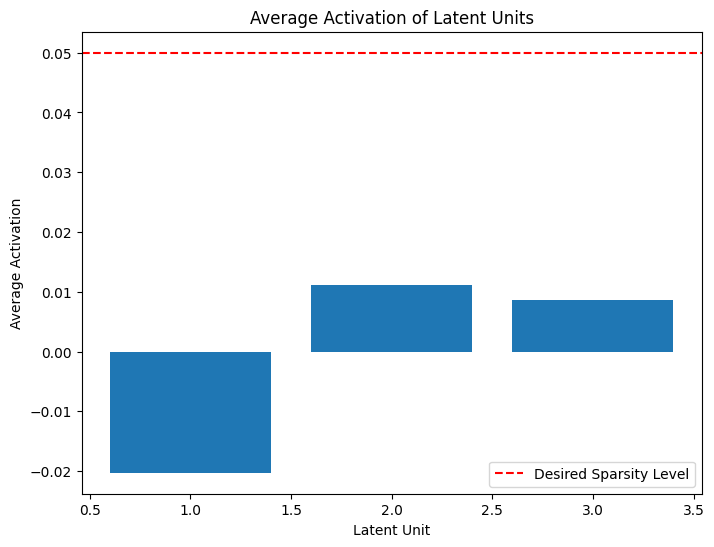

In [269]:
# Visualization 1: Average Activation of Each Latent Unit

# Compute the average activation of each latent unit over the dataset
average_activation = latent_reps_np.mean(axis=0)

# Plot the average activation
plt.figure(figsize=(8, 6))
plt.bar(range(1, latent_reps_np.shape[1] + 1), average_activation)
plt.axhline(y=sparsity_param, color="r", linestyle="--", label="Desired Sparsity Level")
plt.title("Average Activation of Latent Units")
plt.xlabel("Latent Unit")
plt.ylabel("Average Activation")
plt.legend()
plt.show()

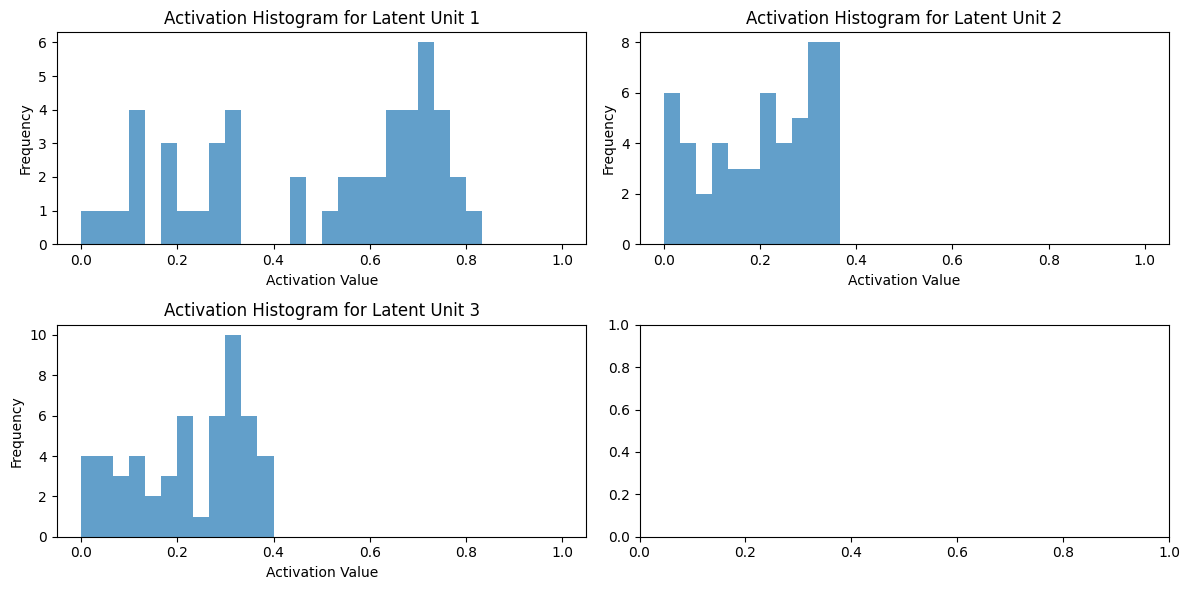

In [270]:
# Visualization 2: Histogram of Activations for Each Latent Unit

# Plot histograms of activations for each latent unit

latent_dim = latent_reps_np.shape[1]
fig, axes = plt.subplots(int(np.ceil(latent_dim / 2)), 2, figsize=(12, 2 * latent_dim))
axes = axes.flatten()

for i in range(latent_dim):
    axes[i].hist(latent_reps_np[:, i], bins=30, range=(0, 1), alpha=0.7)
    axes[i].set_title(f"Activation Histogram for Latent Unit {i+1}")
    axes[i].set_xlabel("Activation Value")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

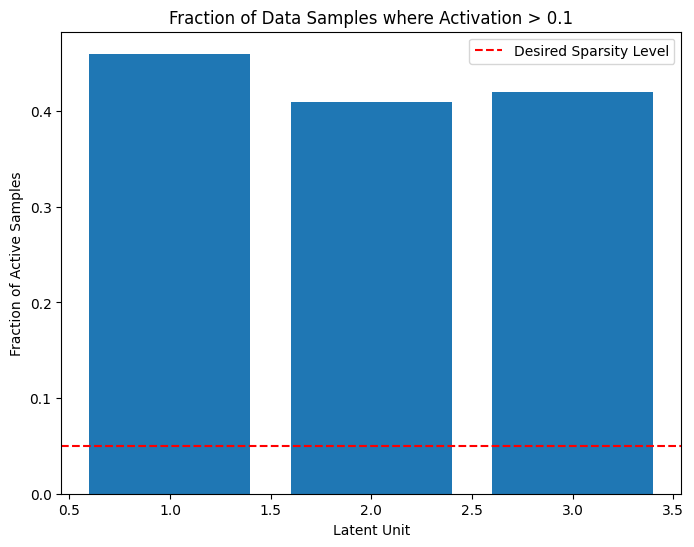

In [271]:
# Visualization 3: Sparsity Level Across Data Samples

# Define a threshold to consider a unit as 'active' (e.g., activation > 0.1)
threshold = 0.1

# Compute the fraction of samples where each latent unit is active
active_counts = (latent_reps_np > threshold).sum(axis=0)
fraction_active = active_counts / latent_reps_np.shape[0]

# Plot the fraction of activation
plt.figure(figsize=(8, 6))
plt.bar(range(1, latent_dim + 1), fraction_active)
plt.axhline(y=sparsity_param, color="r", linestyle="--", label="Desired Sparsity Level")
plt.title(f"Fraction of Data Samples where Activation > {threshold}")
plt.xlabel("Latent Unit")
plt.ylabel("Fraction of Active Samples")
plt.legend()
plt.show()

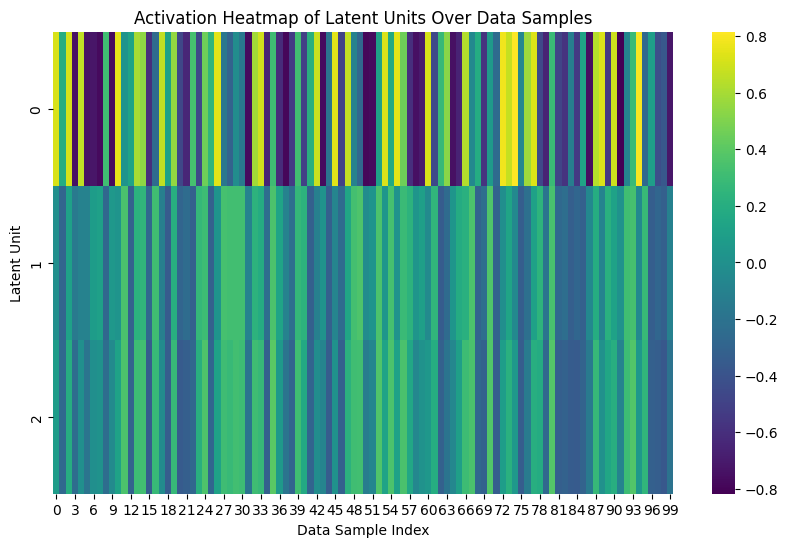

In [248]:
# Visualization 4: Activation Heatmap Over Data Samples

# You can display the activation patterns over samples
plt.figure(figsize=(10, 6))
sns.heatmap(latent_reps_np.T, cmap="viridis", cbar=True)
plt.title("Activation Heatmap of Latent Units Over Data Samples")
plt.xlabel("Data Sample Index")
plt.ylabel("Latent Unit")
plt.show()

In [272]:
from sklearn.model_selection import train_test_split

# Convert tensors to numpy arrays
latent_reps_np = latent_reps.numpy()
l_np = l.numpy()
angles_np = angles.numpy()

# Split data into training and test sets
X_train, X_test, y_linear_train, y_linear_test = train_test_split(
    latent_reps_np,
    l_np,
    test_size=0.2,
    random_state=42,
)
_, _, y_angle_train, y_angle_test = train_test_split(
    latent_reps_np,
    angles_np,
    test_size=0.2,
    random_state=42,
)

In [273]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train the linear regression model for the linear feature
linear_probe = LinearRegression()
linear_probe.fit(X_train, y_linear_train)

# Predict on the test set
y_linear_pred = linear_probe.predict(X_test)

# Evaluate performance
mse_linear = mean_squared_error(y_linear_test, y_linear_pred)
print(f"Linear Probe MSE for Linear Feature: {mse_linear:.6f}")

Linear Probe MSE for Linear Feature: 0.094832


In [274]:
# Train the linear regression model for the angle
angle_probe = LinearRegression()
angle_probe.fit(X_train, y_angle_train)

# Predict on the test set
y_angle_pred = angle_probe.predict(X_test)

# Evaluate performance
mse_angle = mean_squared_error(y_angle_test, y_angle_pred)
print(f"Linear Probe MSE for Angle: {mse_angle:.6f}")

Linear Probe MSE for Angle: 1.485736


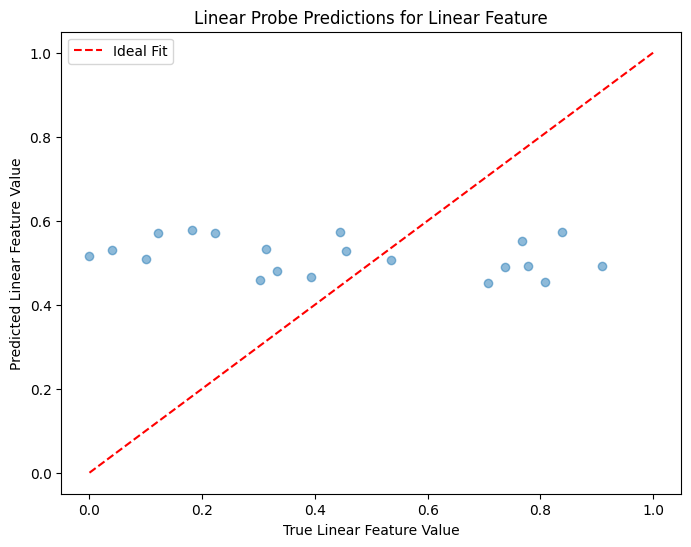

In [275]:
import matplotlib.pyplot as plt

# Plot true vs predicted values for the linear feature
plt.figure(figsize=(8, 6))
plt.scatter(y_linear_test, y_linear_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], "r--", label="Ideal Fit")
plt.title("Linear Probe Predictions for Linear Feature")
plt.xlabel("True Linear Feature Value")
plt.ylabel("Predicted Linear Feature Value")
plt.legend()
plt.show()

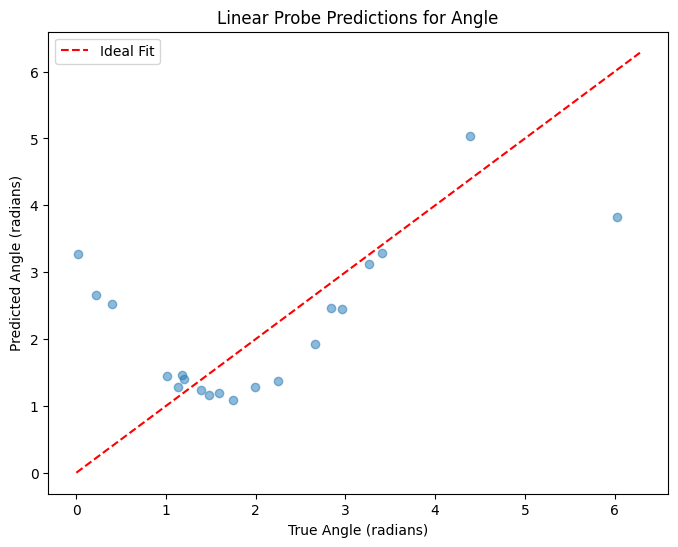

In [276]:
# Plot true vs predicted values for the angle
plt.figure(figsize=(8, 6))
plt.scatter(y_angle_test, y_angle_pred, alpha=0.5)
plt.plot([0, 2 * np.pi], [0, 2 * np.pi], "r--", label="Ideal Fit")
plt.title("Linear Probe Predictions for Angle")
plt.xlabel("True Angle (radians)")
plt.ylabel("Predicted Angle (radians)")
plt.legend()
plt.show()